# Mooring Synthesis of Initial NC data (offline)

## 22BSM-2A

- from netcdf files
- plot all depths of each parameter on each other for comparative purposes
- Temperature, Salinity, Pressure in this notebook.  See companion for Oxygen, Chlor, ADCP/currents, etc

In [5]:
import xarray as xa
import pandas as pd
import numpy as np
import cmocean

In [6]:
#wrap the plot in image settings for visual appeal
# may be able to make this cleaner or just a preset
%run '../../settings/mpl_plot_settings.py'

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker


/Users/bell/Programs/ECOFOCI_Processing_Archive/settings/mpl_plot_settings.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


In [41]:
ncfiles = '/Users/bell/ecoraid/2022/Moorings/22bsm2a/final_data_cf/22bs*s*.nc'

mfd = xa.open_mfdataset(ncfiles)
mfd = mfd.median(dim=['latitude','longitude']) #as long as one isntrument isn't at the same depth on two platforms

## Temperature (full temporal resolution)

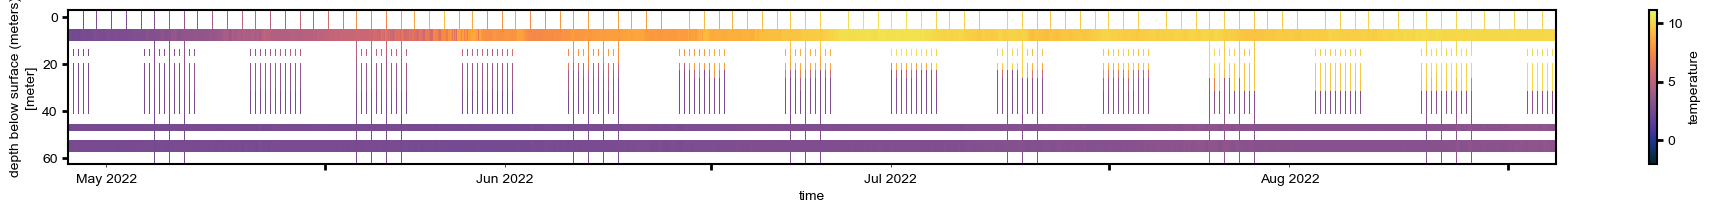

In [42]:
upper_temp = mfd.temperature.max(axis=0).max(axis=0).values
lower_temp = -2

fig, ax = plt.subplots(1,figsize=(24, 2))
mfd.temperature.T.plot(ax=ax,yincrease=False,vmin=lower_temp,vmax=upper_temp,cmap=cmocean.cm.thermal)


ax.xaxis.set_major_locator(DayLocator(bymonthday=1))
ax.xaxis.set_minor_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_formatter(DateFormatter('%b %Y'))
ax.xaxis.set_major_formatter(DateFormatter(''))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

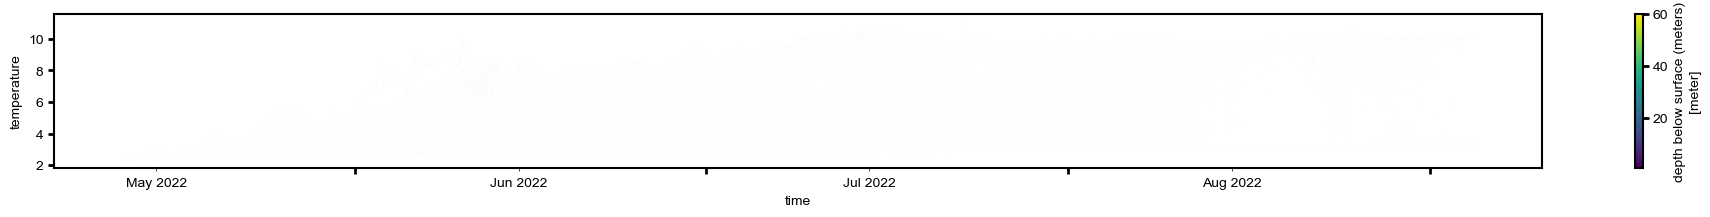

In [44]:
fig, ax = plt.subplots(1,figsize=(24, 2))
mfd.plot.scatter(x="time",y="temperature",hue="depth",s=1,ax=ax)


ax.xaxis.set_major_locator(DayLocator(bymonthday=1))
ax.xaxis.set_minor_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_formatter(DateFormatter('%b %Y'))
ax.xaxis.set_major_formatter(DateFormatter(''))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

**Note:** not everything has constant sample frequencies so if nan's are in the mix, then lineplots are less useful (see plot below)
Will want to resample to hourly or daily to evaluate those

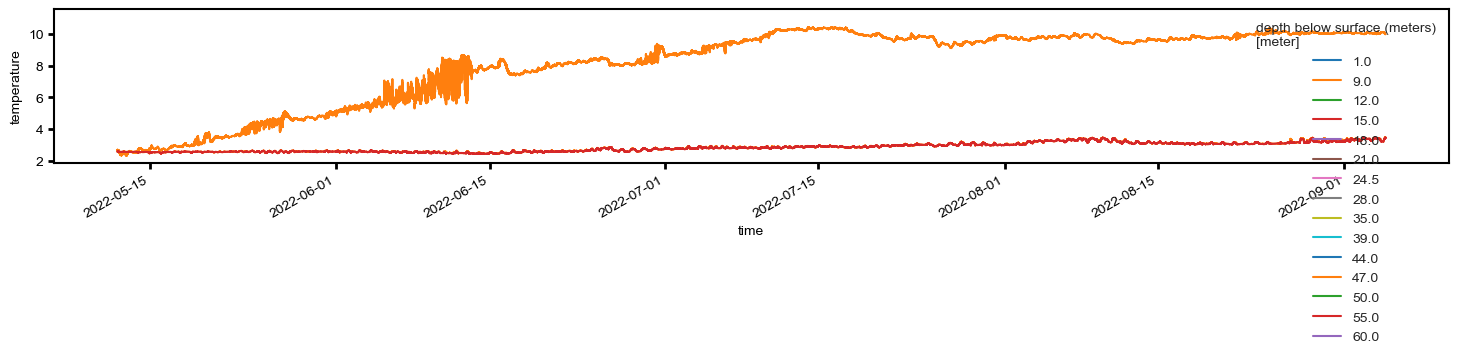

In [46]:
fig, ax = plt.subplots(1,figsize=(18, 2))
mfd.temperature.plot.line(x="time",hue="depth",ax=ax);


## Salinity(full temporal resolution)

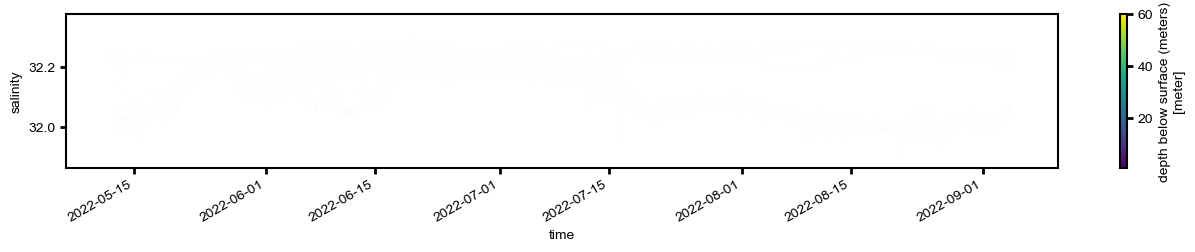

In [47]:
fig, ax = plt.subplots(1,figsize=(16, 2))
mfd.plot.scatter(x="time",y="salinity",hue="depth",s=1,ax=ax)

## Pressure (full temporal resolution)

KeyError: 'pressure'

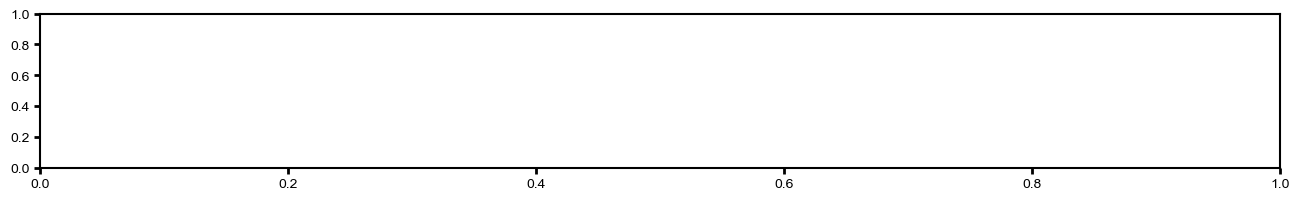

In [49]:
fig, ax = plt.subplots(1,figsize=(16, 2))
mfd.plot.scatter(x="time",y="pressure",hue="depth",s=1,ax=ax)

## Hourly/Interpolated plots Plots

Because of the different timebases... quickly either interpolate (linearly) or downsample (this seems slower) to plot all series

In [ ]:
# mfd_hourly = mfd.resample(time='1H').median() #not fast
mfd_up = mfd.interpolate_na("time")

In [ ]:
fig, ax = plt.subplots(1,figsize=(16, 2))
mfd_up.temperature.plot(x="time",hue="depth",ax=ax);

AttributeError: 'Dataset' object has no attribute 'salinity'

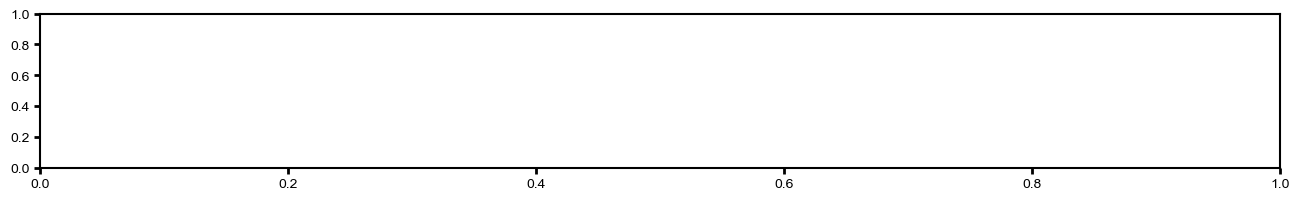

In [50]:
fig, ax = plt.subplots(1,figsize=(16, 2))
mfd_up.salinity.plot(x="time",hue="depth",ax=ax);

In [ ]:
upper_temp = mfd_up.temperature.max(axis=0).max(axis=0).values
lower_temp = -2

fig, ax = plt.subplots(1,figsize=(16, 2))
mfd_up.temperature.T.plot(ax=ax,yincrease=False,vmin=lower_temp,vmax=14,cmap=cmocean.cm.thermal)

## Chlorophyll Hourly Interpolated Plots

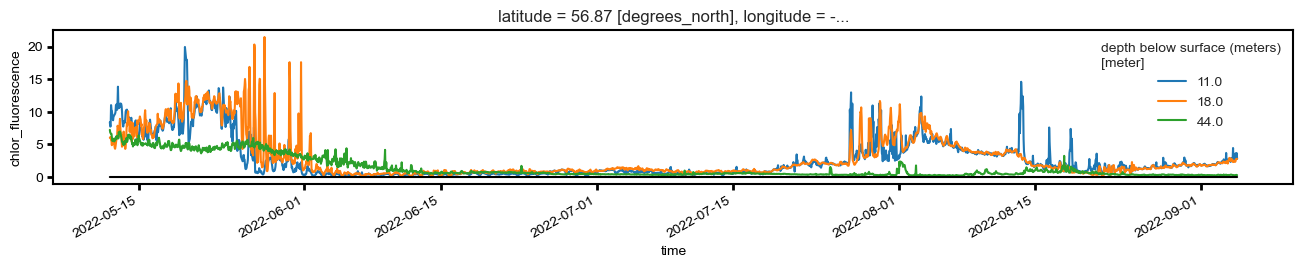

In [6]:
fig, ax = plt.subplots(1,figsize=(16, 2))
mfd_up.chlor_fluorescence.plot(x="time",hue="depth",ax=ax);
(mfd_up.isel({'depth':0}).chlor_fluorescence*0).plot(ax=ax,c='k',add_legend=False); #zeroline

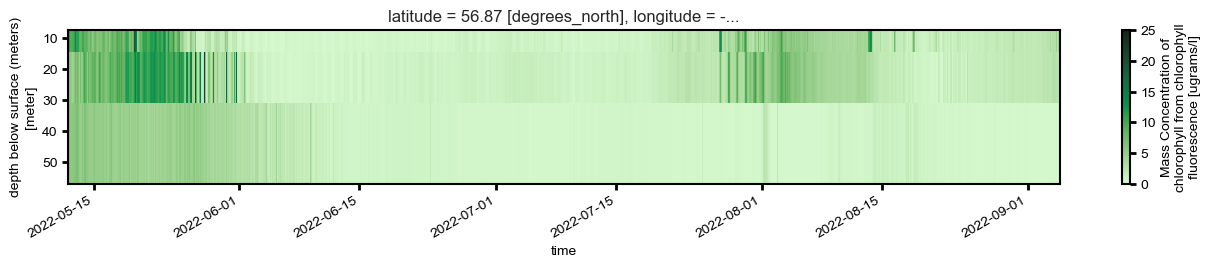

In [7]:
upper = 25
lower = 0

fig, ax = plt.subplots(1,figsize=(16, 2))
mfd_up.chlor_fluorescence.T.plot(ax=ax,yincrease=False,vmin=lower,vmax=upper,cmap=cmocean.cm.algae)

## Compare Timeseries to CTD Casts


- Recovery CTDXXX on Sikuliaq cruise, not yet obtained.

In [17]:
import ecofocipy.io.erddap as erddap

In [18]:
url = "http://ecofoci-field.pmel.noaa.gov:8080/erddap"

erddap.test_erddap_connection(url=url) #basic test for connection to internal server, no response is a good thing

In [20]:
#grap deploy/recover cast data from erddap hosted sets - you have to know which profile you want though
depcast = erddap.erddapCTDretrieve(url=url,cruiseid='dy2206',qclevel='preliminary',concastno='001')
# reccast = erddap.erddapCTDretrieve(url=url,cruiseid='dy2012',qclevel='preliminary',concastno='024')


## QC Notes



(PJS needs to vet these)

## Generate to_edit files for PJS

- these are usually salinity focused and need the ctd casts as well as the salinity timeseries.
- save the native time scale, not the interpolated or upscaled version

In [18]:
with pd.ExcelWriter('19bs8a_salinity_to_edit.xlsx') as writer:  

    for depthkey in mfd.to_dataframe().salinity.groupby(level=[1]).groups.keys():
        if not (mfd.to_dataframe().salinity.groupby(level=[1]).get_group(depthkey).dropna(how='all')).empty:
            print(f'saving {depthkey}')
            (mfd.to_dataframe().salinity.groupby(level=[1]).get_group(depthkey).dropna(axis=0)).to_excel(writer, sheet_name=str(depthkey))

    depcast.to_excel(writer, sheet_name=depcast.profile_id.unique()[0])
    # reccast.to_excel(writer, sheet_name=reccast.profile_id.unique()[0])

saving 6.0
saving 12.0
saving 24.5
saving 44.0
saving 50.0
saving 60.0
